In [1]:
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from bs_fdbck.constants import measurements_path, path_outdata, path_extract_latlon_outdata
import dask.array as da
from dask.diagnostics import ProgressBar
import seaborn as sns

 from pathlib import Path 
 Path(path).mkdir(exist_ok=True, parents=True)


In [2]:
def make_fn(case, v_x, v_y):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'scat_{case}_{_x}_{_y}.png'
    return plot_path /f



In [3]:
xr.set_options(keep_attrs=True) 

### Settings

In [4]:
lat_smr = 61.85
lon_smr = 24.28
model_lev_i=-1

In [5]:
case_name = 'OsloAero_intBVOC_f09_f09_mg17_full'

In [6]:
fn = path_extract_latlon_outdata/ case_name/f'{case_name}.h1._2012-01-01-2015-01-01_concat_subs_22.0-30.0_60.0-66.0.nc'
fn_comb_lev1 = path_extract_latlon_outdata/ case_name/f'{case_name}.h1._2012-01-01-2015-01-01_concat_subs_22.0-30.0_60.0-66.0_lev1.nc'
fn_comb_lev1_final = path_extract_latlon_outdata/ case_name/f'{case_name}.h1._2012-01-01-2015-01-01_concat_subs_22.0-30.0_60.0-66.0_lev1_final.nc'
fn_comb_lev1_final_csv = path_extract_latlon_outdata/ case_name/f'{case_name}.h1._2012-01-01-2015-01-01_concat_subs_22.0-30.0_60.0-66.0_lev1_final.csv'

In [7]:
fn2 = fn.parent / f'{fn.stem}_sort.nc'

In [8]:
cases = [case_name]

In [9]:
plot_path = Path('Plots')

In [10]:
varl =['DOD500','DOD440','ACTREL','ACTNL','TGCLDLWP', #,'SOA_A1',
       'H2SO4','SOA_LV','COAGNUCL','FORMRATE','T'
       ,'FCTL',
       'TOT_CLD_VISTAU','TOT_ICLD_VISTAU','TGCLDCWP',
       'CLDFREE',
      'SOA_NA','SOA_A1','OM_NI','OM_AI','OM_AC','SO4_NA','SO4_A1','SO4_A2','SO4_AC','SO4_PR',
      'BC_N','BC_AX','BC_NI','BC_A','BC_AI','BC_AC','SS_A1','SS_A2','SS_A3','DST_A2','DST_A3', 
       'FSDSC','FSDSCDRF'
      ] 

## Station variables

In [153]:
varl_st = [      'SOA_NA','SOA_A1','OM_NI','OM_AI','OM_AC','SO4_NA','SO4_A1','SO4_A2','SO4_AC','SO4_PR',
      'BC_N','BC_AX','BC_NI','BC_A','BC_AI','BC_AC','SS_A1','SS_A2','SS_A3','DST_A2','DST_A3',
          'CLDFREE']


varl_cl = ['TOT_CLD_VISTAU','TOT_ICLD_VISTAU','TGCLDCWP','TGCLDLWP','TGCLDIWP',
           'TOT_CLD_VISTAU_s','TOT_ICLD_VISTAU_s','optical_depth',
       'CLDFREE',
       'FCTL',
           'ACTREL','ACTNL','TGCLDLWP',
                  'FSDSC','FSDSCDRF',
           'FCTI',
           'FCTL',
           'FLNS',
           'FLNSC',
           'FLNT',
           'FLNTCDRF',
           'FLNT_DRF',
           'FLUS',
           'FLUTC','FORMRATE',
'FREQI',
'FREQL',
'FSDSCDRF',
'FSDS_DRF',
'FSNS',
'FSNSC',
'FSNT',
'FSNTCDRF',
'FSNT_DRF',
'FSUS_DRF',
'FSUTADRF',
          ]

## If file not already createad already, skip this part

In [12]:
def compute_total_tau(ds_mod):
    ds_mod['TOT_ICLD_VISTAU_s'] = ds_mod['TOT_ICLD_VISTAU'].sum('lev')
    ds_mod['TOT_CLD_VISTAU_s'] = ds_mod['TOT_CLD_VISTAU'].sum('lev')
    return ds_mod

In [13]:
if not fn_comb_lev1.exists():
    ds_mod = xr.open_dataset(fn, chunks = {'time':48})#[fn1,fn2])#.sortby('time')
    #ds_mod2 = xr.open_dataset(fn2, chunks = {'time':48})

    ds_mod = compute_total_tau(ds_mod)

    ds_mod = ds_mod.sortby('time')#.sel(time=slice('2012','2014'))

    ds_mod = ds_mod.isel(lev = model_lev_i)


    delayed_obj = ds_mod.to_netcdf(fn_comb_lev1, compute=False)
    print('hey')
    with ProgressBar(): 
        results = delayed_obj.compute()

## If file createad already, skip to here

### Select hyytiala grid cell: 

We use only hyytiala for org etc, but all grid cells over finland for cloud properties

In [14]:
def broadcase_station_data(ds_all):
    ds_sel = ds_all.sel(lat = lat_smr, lon= lon_smr, method='nearest')
    ds_1, ds_2 =xr.broadcast(ds_sel, ds_all)
    for v in varl_st:
        ds_all[v] = ds_1[v]

    return ds_all


def compute_optical_thickness(ds):
    SW_down_surf = ds['FSDS_DRF']


    SW_down_surf_cs = ds['FSDSCDRF']


    transmittance = SW_down_surf/SW_down_surf_cs




    opt_depth = - np.log(transmittance)


    ds['optical_depth'] =  opt_depth 
    return ds 

def change_units_and_compute_vars(ds):
    

    ds = ds.where(ds['CLDFREE']<0.8)
    for v in ['TGCLDLWP', 'TGCLDIWP', 'TGCLDCWP']:
        if v in ds.data_vars:
            if ds[v].attrs['units'] == 'kg/m2':
                ds[v] = ds[v] * 1000
                ds[v].attrs['units'] = 'g/m2'
    rho = pressure * 100 / (R * ds['T'])
    ds['rho'] = rho
    ds['ACTNL_incld'] = ds['ACTNL'] / ds['FCTL']
    ds['ACTREL_incld'] = ds['ACTREL'] / ds['FCTL']
    ds['T_C'] = ds['T'] - 273.15
    
    ds['TGCLDCWP_incld'] = ds['TGCLDCWP'] / (1 - ds['CLDFREE'])
    ds['TGCLDLWP_incld'] = ds['TGCLDLWP'] / (1 - ds['CLDFREE'])
    ds = ds.where(ds['CLDFREE'] < 1)
    ls_so4 = [c for c in ds.data_vars if 'SO4_' in c]  # ['SO4_NA']
    for s in ['SOA_NA', 'SOA_A1', 'OM_AC', 'OM_AI', 'OM_NI'] + ls_so4:
        un = '$\micro$g/m3'
        if ds[s].attrs['units'] != un:
            ds[s] = ds[s] * ds['rho'] * kg2ug
            ds[s].attrs['units'] = un
    ds['SOA'] = ds['SOA_NA'] + ds['SOA_A1']
    ds['OA'] = ds['SOA_NA'] + ds['SOA_A1'] + ds['OM_AC'] + ds['OM_AI'] + ds['OM_NI']
    ds['POA'] = ds['OM_AC'] + ds['OM_AI'] + ds['OM_NI']
    ds['SO4'] = 0
    
    
    
    for s in ls_so4:
        print(s)

        # print(ds[s].mean())
        ds['SO4'] = ds['SO4'] + ds[s]
    
    ds = compute_optical_thickness(ds)
    return ds

In [15]:
if not fn_comb_lev1_final.exists():
    ds_all = xr.open_dataset(fn_comb_lev1).isel(ilev=model_lev_i)
    ds_sel = ds_all.sel(lat = lat_smr, lon= lon_smr, method='nearest')#.isel( ilev=model_lev_i)#.load()
    ds_all = ds_all.isel(
        #ilev=-1,
        # cosp_tau_modis=0,
        #                                                    cosp_tau=0,
        #                                                   cosp_dbze=0,
        #                                                    cosp_ht=0,
        #                                                    cosp_prs = 0,
        #                                                   cosp_reffice=0,
        #                                                    cosp_htmisr=0,
        #                                                    cosp_reffliq=0,
        #                                                    cosp_scol=0,
        #                                                    cosp_sr=0,
        #                                                    cosp_sza=0,
        nbnd=0
    ).squeeze()
    ds_all = broadcase_station_data(ds_all)
    ds_all = change_units_and_compute_vars(ds_all)
    

    delayed_obj = ds_all.to_netcdf(fn_comb_lev1_final, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()

### Broadcast ds_sel to same grid 

In [16]:

ds_all = xr.open_dataset(fn_comb_lev1_final)

In [17]:
dic_ds = dict()
dic_ds[case_name] =ds_all

In [18]:
R = 287.058
pressure = 1000. #hPa
kg2ug = 1e9

In [19]:
ds_all['hour'] = ds_all['time.hour']

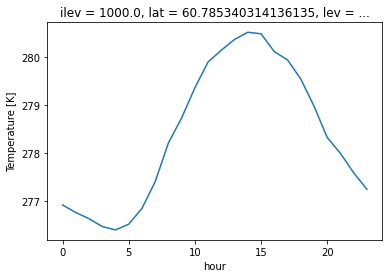

In [20]:
ds_all['T'].groupby(ds_all['hour']).mean(['time']).isel(lat=0,lon=0).plot()

In [21]:
for v in ds_all.data_vars:
    print(v)

ABSVIS
ACTNI
ACTNL
ACTREI
ACTREL
AEROD_v
AOD_VIS
AREL
ASYMMDRY
AWNC
BC_A
BC_AC
BC_AI
BC_AX
BC_N
BC_NI
BETOTVIS
BS550AER
CCN1
CCN2
CCN3
CCN4
CCN5
CCN6
CCN7
CCN_B
CDNUMC
CLDFREE
CLDTOT
COAGNUCL
D500_BC
D500_DU
D500_POM
D500_SO4
D500_SS
DAERH2O
DER
DERGT05
DERLT05
DMS
DOD440
DOD500
DOD550
DOD670
DOD870
DST_A2
DST_A3
EC550AER
FCTI
FCTL
FLNS
FLNSC
FLNT
FLNTCDRF
FLNT_DRF
FLUS
FLUTC
FORMRATE
FREQI
FREQL
FSDSCDRF
FSDS_DRF
FSNS
FSNSC
FSNT
FSNTCDRF
FSNT_DRF
FSUS_DRF
FSUTADRF
GR
GRH2SO4
GRIDAREA
GRSOA
H2SO4
MMR_AH2O
NCONC01
NCONC02
NCONC03
NCONC04
NCONC05
NCONC06
NCONC07
NCONC08
NCONC09
NCONC10
NCONC11
NCONC12
NCONC13
NCONC14
NMR01
NMR02
NMR03
NMR04
NMR05
NMR06
NMR07
NMR08
NMR09
NMR10
NMR11
NMR12
NMR13
NMR14
NNAT_0
NUCLRATE
OD550DRY
OM_AC
OM_AI
OM_NI
P0
PM25
PM2P5
PMTOT
PS
RHW
SFisoprene
SFmonoterp
SIGMA01
SIGMA02
SIGMA03
SIGMA04
SIGMA05
SIGMA06
SIGMA07
SIGMA08
SIGMA09
SIGMA10
SIGMA11
SIGMA12
SIGMA13
SIGMA14
SO2
SO4_A1
SO4_A2
SO4_AC
SO4_NA
SO4_PR
SOA_A1
SOA_LV
SOA_NA
SOA_SV
SS_A1
SS_A2
SS_A3
T
TG

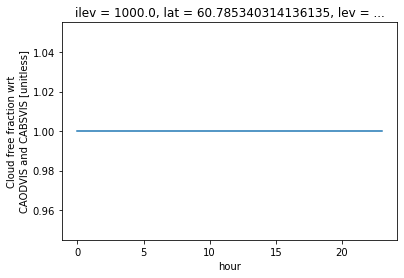

In [22]:
(1-ds_all['CLDFREE']).groupby(ds_all['hour']).max(['time']).isel(lat=0,lon=0).plot()

In [23]:
a = ds_all['TGCLDCWP']/(1-ds_all['CLDFREE'])#.where(ds_all['CLDFREE']<.9))
#ds_all['TGCLDCWP']/(1-ds_all['CLDFREE'])

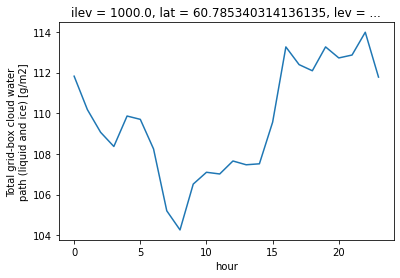

In [24]:
a.groupby(ds_all['hour']).mean(['time']).isel(lat=0,lon=1).plot()

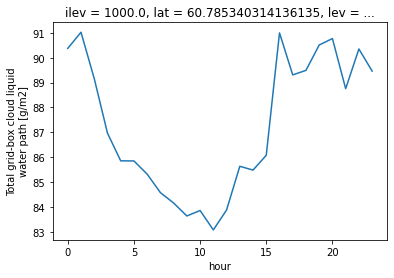

In [25]:
ds_all['TGCLDLWP_incld'].groupby(ds_all['hour']).mean(['time']).isel(lat=0,lon=0).plot()

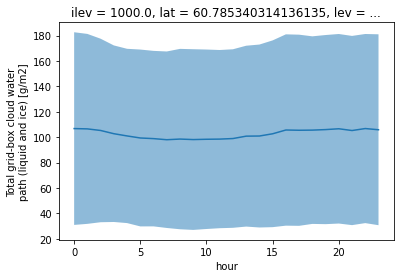

In [26]:
mean = ds_all['TGCLDCWP'].groupby(ds_all['hour']).mean(['time']).isel(lat=0,lon=0)
std =ds_all['TGCLDCWP'].groupby(ds_all['hour']).std(['time']).isel(lat=0,lon=0)#.plot()
plt.fill_between(std['hour'],mean - 0.5*std,  mean + 0.5*std, alpha=.5)
mean.plot()

In [27]:
#ds['CLDFREE'].max()

In [79]:
def get_dic_df_mod():

    dic_df = dict()
    #dic_df_sm = dict()

    for ca in dic_ds.keys():
        

        ds = dic_ds[ca]
        #ds = change_units_and_compute_vars(ds)

        print('hallo')
        print(ds)
                
        hours_we_want = (ds['hour']>8) &   (ds['hour']<14) 
        for v in varl_cl:
            if v in ds.data_vars:
                ds[v] = ds[v].where(hours_we_want)

    
        
        ds_sel_median = ds.resample({'time':'D'}).median()

        

        ds_sel_median['month']=ds_sel_median['time.month']
        #df_s['ACTNL'].plot()
        ds_sel_median['isJuly'] = ds_sel_median['month']==7
        ds_sel_median['isAug'] = ds_sel_median['month']==8
        ds_sel_median['isSummer'] = (ds_sel_median['isJuly'] |ds_sel_median['isAug'])
        
        #ds_sel_median = ds_sel_median.where(ds_sel_median['month']

        ds_sel_median = ds_sel_median.where(ds_sel_median['isSummer'])#['month']

        df = ds_sel_median.to_dataframe()
    

        df = df.drop([co for co in df.columns if (('lat_' in co)|('lon_' in co))], 
                     axis=1)

        months = (df.index.get_level_values(0).month==7 )|(df.index.get_level_values(0).month==8  )

        df.loc[:,'year'] = df.index.get_level_values(0).year.values

        #df_s.index = df_s.index.rename('date')
        #df_merge = df_s#pd.merge(df_s, df_hyy_1, right_on='date', left_on='date')
        
        #df_s['year'] = df_s.index.get_level_values(0).year

        
        dic_df[ca] = df
        

    return dic_df




#dic_df = get_dic_df_mod()

In [154]:
    #if not fn_comb_lev1_final_csv.exists():
    dic_df = get_dic_df_mod()
    
    df_mod = dic_df[case_name]
    df_mod.to_csv(fn_comb_lev1_final_csv)

hallo
<xarray.Dataset>
Dimensions:            (time: 26281, lat: 6, lon: 7)
Coordinates:
    ilev               float64 1e+03
  * lat                (lat) float64 60.79 61.73 62.67 63.61 64.55 65.5
    lev                float64 992.6
  * lon                (lon) float64 22.5 23.75 25.0 26.25 27.5 28.75 30.0
  * time               (time) datetime64[ns] 2012-01-02 ... 2015-01-01
Data variables: (12/192)
    ABSVIS             (time, lat, lon) float32 ...
    ACTNI              (time, lat, lon) float32 ...
    ACTNL              (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    ACTREI             (time, lat, lon) float32 ...
    ACTREL             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    AEROD_v            (time, lat, lon) float32 ...
    ...                 ...
    SOA                (time, lat, lon) float32 ...
    OA                 (time, lat, lon) float32 ...
    POA                (time, lat, lon) float32 ...
    SO4                (time, lat, lon) fl

In [35]:
df_mod = pd.read_csv(fn_comb_lev1_final_csv, index_col=[0,1,2] )

In [155]:
df_mod = df_mod[df_mod['CLDFREE']<80]#.index.get_level_values(1)

In [156]:
mask_liq_cloudtop = df_mod['FCTL']>0.0001

In [157]:
df_mod.loc[:,'mask_liq_cloudtop'] = mask_liq_cloudtop

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


<AxesSubplot:xlabel='time'>

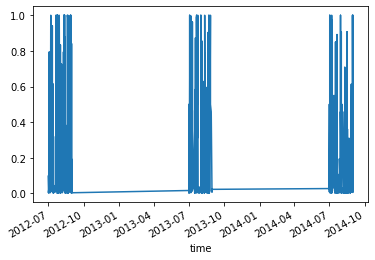

In [158]:
df_mod[mask_liq_cloudtop].reset_index().set_index('time')['FCTL'].plot()#ylim=[-.0,.01])

In [159]:
_df = df_mod.reset_index()

In [160]:
a

,ABSVIS,ACTNI,ACTNL,ACTREI,ACTREL,AEROD_v,AOD_VIS,AREL,ASYMMDRY,AWNC,...,OA,POA,SO4,optical_depth,hour,month,ilev,lat,lev,lon
time,,,,,,,,,,,,,,,,,,,,,
2012-07-30 09:00:00,0.010885,7775.466797,0.0,55.082565,0.000000,NaN,0.204664,0.0,0.605345,0.0,...,8.309096,2.158258,5.891878,0.501735,9.0,7.0,1000.0,60.78534,992.556095,22.5
2012-08-03 09:00:00,0.008141,24278.468750,0.0,54.726315,0.000000,NaN,0.208708,0.0,0.600366,0.0,...,2.472976,0.898424,1.070514,0.838300,9.0,8.0,1000.0,60.78534,992.556095,22.5
2012-08-06 13:00:00,0.004514,124836.718750,0.0,40.819710,0.000000,NaN,0.117155,0.0,0.617100,0.0,...,1.909446,0.913857,0.668090,1.075974,13.0,8.0,1000.0,60.78534,992.556095,22.5
2012-08-29 09:00:00,0.002490,0.000000,12220985.0,0.000000,13.481055,NaN,0.062990,0.0,0.580974,0.0,...,2.039722,0.511349,0.714745,1.047789,9.0,8.0,1000.0,60.78534,992.556095,22.5
2013-07-18 13:00:00,0.004686,1448.838257,0.0,51.916546,0.000000,NaN,0.138927,0.0,0.599644,0.0,...,2.357701,1.928413,0.412872,1.079461,13.0,7.0,1000.0,60.78534,992.556095,22.5
2013-08-07 10:00:00,0.007818,28758.230469,0.0,57.505348,0.000000,NaN,0.122866,0.0,0.585412,0.0,...,3.394918,1.078227,0.842650,0.464476,10.0,8.0,1000.0,60.78534,992.556095,22.5
2013-08-07 11:00:00,0.007884,9551.041016,0.0,54.630653,0.000000,NaN,0.118195,0.0,0.585322,0.0,...,3.881902,1.150465,1.314961,0.452437,11.0,8.0,1000.0,60.78534,992.556095,22.5
2014-07-28 12:00:00,0.008260,13404.931641,0.0,23.023918,0.000000,NaN,0.207915,0.0,0.539766,0.0,...,6.476911,1.607159,2.106394,1.008214,12.0,7.0,1000.0,60.78534,992.556095,22.5
2014-07-30 13:00:00,0.007557,83706.804688,0.0,23.288994,0.000000,NaN,0.113357,0.0,0.569828,0.0,...,3.337577,0.651980,0.832894,0.481750,13.0,7.0,1000.0,60.78534,992.556095,22.5


In [161]:
ds_all['FSDS_DRF']

<xarray.DataArray 'FSDS_DRF' (time: 26281, lat: 6, lon: 7)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],
...
       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    ilev     float64 1e+03
  * lat      (lat) float64 60.79 61.73 62.67 63.61 64.55 65.5
    lev      float64 992.6
  * lon      (lon) float64 22.5 23.75 25.0 26.25 27.5 28.75 30.0
  * time     (time) datetime64[ns] 2012-01-02 2012-01-02T01:00:00 ... 2015-01-01
Attributes:
    units:         W/m^2
    long_name:     SW downelling flux at surface
    cell_methods:  time: mean

In [162]:
_ds = ds_all.isel(lat=0, lon=0)

In [163]:
_ds['month'] = _ds['time.month']

In [164]:
_ds = _ds.where((_ds['month']==7) |(_ds['month']==8))  

In [165]:
_df2 = _ds.to_dataframe()

In [166]:
_df2 = _df2[(_df2['month']==7) |(_df2['month']==8)] 

In [167]:
_df2

,ABSVIS,ACTNI,ACTNL,ACTREI,ACTREL,AEROD_v,AOD_VIS,AREL,ASYMMDRY,AWNC,...,OA,POA,SO4,optical_depth,hour,month,ilev,lat,lev,lon
time,,,,,,,,,,,,,,,,,,,,,
2012-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,7.0,1000.0,60.78534,992.556095,22.5
2012-07-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,7.0,1000.0,60.78534,992.556095,22.5
2012-07-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,7.0,1000.0,60.78534,992.556095,22.5
2012-07-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,7.0,1000.0,60.78534,992.556095,22.5
2012-07-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,7.0,1000.0,60.78534,992.556095,22.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-31 19:00:00,0.002954,0.0,NaN,0.0,NaN,NaN,0.055041,0.0,0.641832,0.0,...,1.147666,0.531600,1.001884,NaN,19.0,8.0,1000.0,60.78534,992.556095,22.5
2014-08-31 20:00:00,0.002901,0.0,NaN,0.0,NaN,NaN,0.058471,0.0,0.635907,0.0,...,1.243544,0.573470,0.945874,NaN,20.0,8.0,1000.0,60.78534,992.556095,22.5
2014-08-31 21:00:00,0.002841,0.0,NaN,0.0,NaN,NaN,0.064028,0.0,0.630148,0.0,...,1.328419,0.613383,0.887635,NaN,21.0,8.0,1000.0,60.78534,992.556095,22.5


In [168]:
SW_down_surf = _df2['FSDS_DRF']

In [169]:
SW_down_surf_cs = _df2['FSDSCDRF']

<AxesSubplot:xlabel='time'>

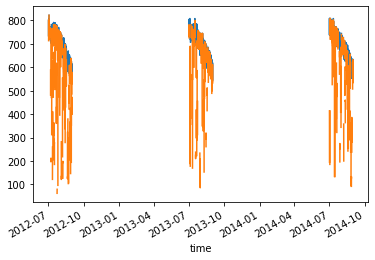

In [170]:
SW_down_surf_cs.plot()
SW_down_surf.plot()

In [171]:
transmittance = SW_down_surf/SW_down_surf_cs

<AxesSubplot:ylabel='Frequency'>

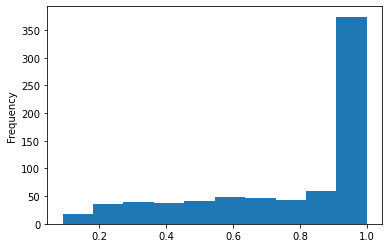

In [172]:
transmittance.plot.hist()

<AxesSubplot:ylabel='Frequency'>

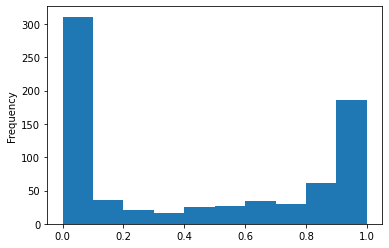

In [173]:
np.exp(-_df2['TOT_CLD_VISTAU_s']).plot.hist()

<AxesSubplot:ylabel='Frequency'>

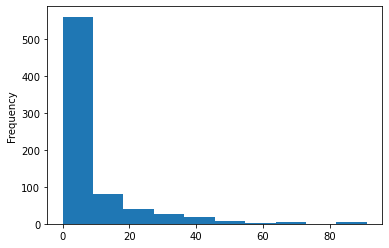

In [174]:
_df2['TOT_CLD_VISTAU_s'].plot.hist()

In [175]:
opt_depth = - np.log(transmittance)

<AxesSubplot:xlabel='time'>

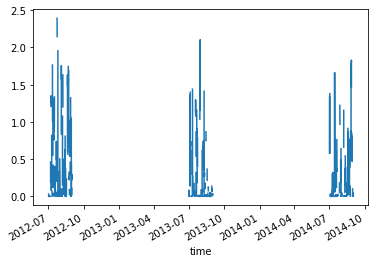

In [176]:
opt_depth.plot()

In [177]:
_df2['optical_depth'] =  opt_depth 

In [178]:
_df2['optical_depth']

time
2012-07-01 00:00:00   NaN
2012-07-01 01:00:00   NaN
2012-07-01 02:00:00   NaN
2012-07-01 03:00:00   NaN
2012-07-01 04:00:00   NaN
                       ..
2014-08-31 19:00:00   NaN
2014-08-31 20:00:00   NaN
2014-08-31 21:00:00   NaN
2014-08-31 22:00:00   NaN
2014-08-31 23:00:00   NaN
Name: optical_depth, Length: 4464, dtype: float32

## Clean hours: 

9 to 15 UTC --> 7-13

In [179]:
hours_we_want = (_df2['hour']>8) &   (_df2['hour']<14) 

<AxesSubplot:xlabel='hour'>

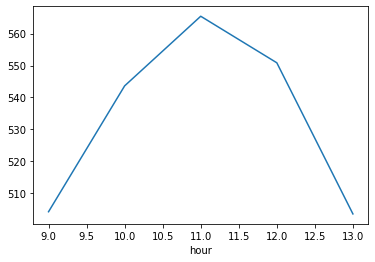

In [180]:
_df2[hours_we_want].groupby(_df2[hours_we_want]['hour'])['FSDS_DRF'].mean().plot()

In [181]:
_df = _df2#[hours_we_want]

In [182]:
a = _df[((_df['TGCLDCWP']>100.0)& (_df['TOT_ICLD_VISTAU_s']<20))& (_df['CLDFREE']<.1) ]
b = _df[~((_df['TGCLDCWP']>100.0)& (_df['TOT_ICLD_VISTAU_s']<20) )& (_df['CLDFREE']<.1)]
#for c in a.columns:
#    print(c)

Text(0, 0.5, 'TOT_CLD_VISTAU_s')

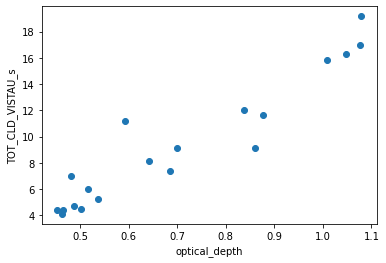

In [183]:
v = 'optical_depth'
v2 = 'TOT_CLD_VISTAU_s'
plt.scatter(a[v],a[v2])#plot(linewidth=0, marker='*')
#plt.scatter(b[v],b[v2])#plot(linewidth=0, marker='*')
##b[v].plot(linewidth=0, marker='*')
plt.xlabel(v)
plt.ylabel(v2)
#plt.xlim([0,5])

Text(0, 0.5, 'TOT_CLD_VISTAU_s')

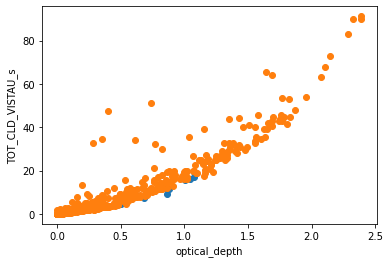

In [184]:
v = 'optical_depth'
v2 = 'TOT_CLD_VISTAU_s'
plt.scatter(a[v],a[v2])#plot(linewidth=0, marker='*')
plt.scatter(b[v],b[v2])#plot(linewidth=0, marker='*')
#b[v].plot(linewidth=0, marker='*')
plt.xlabel(v)
plt.ylabel(v2)

Text(0, 0.5, 'TGCLDCWP')

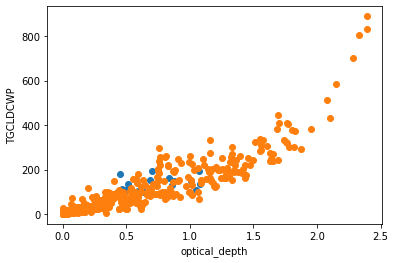

In [185]:
v = 'optical_depth'
v2 = 'TGCLDCWP'
plt.scatter(a[v],a[v2])#plot(linewidth=0, marker='*')
plt.scatter(b[v],b[v2])#plot(linewidth=0, marker='*')
#b[v].plot(linewidth=0, marker='*')
plt.xlabel(v)
plt.ylabel(v2)

In [186]:
c = _df[((_df['TGCLDLWP']>100)& (_df['optical_depth']<.1))& (_df['CLDTOT']>.5) ]
d = _df#[(~((_df['TGCLDLWP']>100)& (_df['optical_depth']<.1)))& (_df['CLDTOT']>.5) ]

print(len(d))
#for c in a.columns:
#    print(c)

4464


Text(0, 0.5, 'TGCLDCWP')

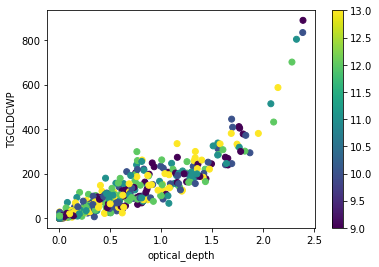

In [187]:
v = 'optical_depth'
v2 = 'TGCLDCWP'
#plt.scatter(c[v],c[v2])#plot(linewidth=0, marker='*')

plt.scatter(d[v],d[v2], c = d['hour'] )#plot(linewidth=0, marker='*')
plt.colorbar()
#b[v].plot(linewidth=0, marker='*')
plt.xlabel(v)
plt.ylabel(v2)

Text(0, 0.5, 'TOT_CLD_VISTAU_s')

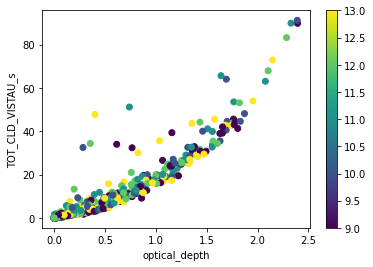

In [188]:
v = 'optical_depth'
v2 = 'TOT_CLD_VISTAU_s'
#plt.scatter(c[v],c[v2])#plot(linewidth=0, marker='*')

plt.scatter(_df[v],_df[v2], c = d['hour'] )#plot(linewidth=0, marker='*')
plt.colorbar()
#b[v].plot(linewidth=0, marker='*')
plt.xlabel(v)
plt.ylabel(v2)

Text(0, 0.5, 'TOT_CLD_VISTAU_s')

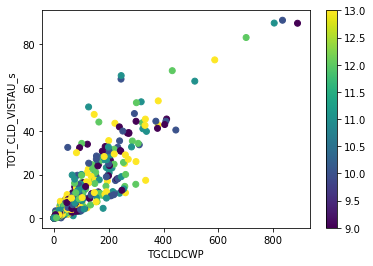

In [189]:
v = 'TGCLDCWP'
v2 = 'TOT_CLD_VISTAU_s'
#plt.scatter(c[v],c[v2])#plot(linewidth=0, marker='*')

plt.scatter(_df[v],_df[v2], c = d['hour'] )#plot(linewidth=0, marker='*')
plt.colorbar()
#b[v].plot(linewidth=0, marker='*')
plt.xlabel(v)
plt.ylabel(v2)

Text(0, 0.5, 'optical_depth')

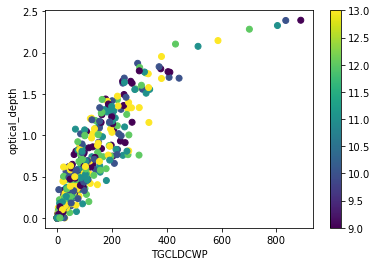

In [190]:
v = 'TGCLDCWP'
v2 = 'optical_depth'
#plt.scatter(c[v],c[v2])#plot(linewidth=0, marker='*')

plt.scatter(_df[v],_df[v2], c = d['hour'] )#plot(linewidth=0, marker='*')
plt.colorbar()
#b[v].plot(linewidth=0, marker='*')
plt.xlabel(v)
plt.ylabel(v2)

Text(0, 0.5, 'TOT_CLD_VISTAU_s')

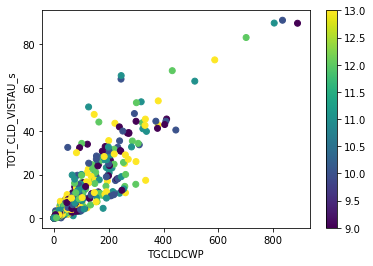

In [191]:
v = 'TGCLDCWP'
v2 = 'TOT_CLD_VISTAU_s'
#plt.scatter(c[v],c[v2])#plot(linewidth=0, marker='*')

plt.scatter(_df[v],_df[v2], c = d['hour'] )#plot(linewidth=0, marker='*')
plt.colorbar()
#b[v].plot(linewidth=0, marker='*')
plt.xlabel(v)
plt.ylabel(v2)

Text(0, 0.5, 'optical_depth')

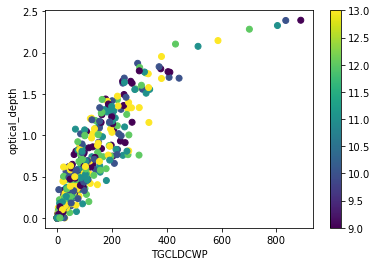

In [192]:
v = 'TGCLDCWP'
v2 = 'optical_depth'
#plt.scatter(c[v],c[v2])#plot(linewidth=0, marker='*')

plt.scatter(_df[v],_df[v2], c = d['hour'] )#plot(linewidth=0, marker='*')
plt.colorbar()
#b[v].plot(linewidth=0, marker='*')
plt.xlabel(v)
plt.ylabel(v2)

Text(0, 0.5, 'TOT_CLD_VISTAU_s')

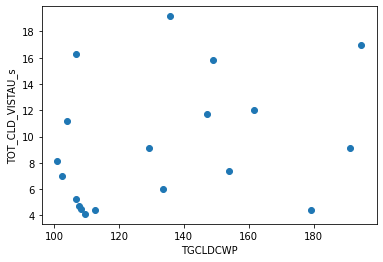

In [193]:
v = 'TGCLDCWP'
v2 = 'TOT_CLD_VISTAU_s'
plt.scatter(a[v],a[v2])#plot(linewidth=0, marker='*')
#plt.scatter(b[v],b[v2])#plot(linewidth=0, marker='*')
#b[v].plot(linewidth=0, marker='*')
plt.xlabel(v)
plt.ylabel(v2)

Text(0, 0.5, 'TOT_ICLD_VISTAU_s')

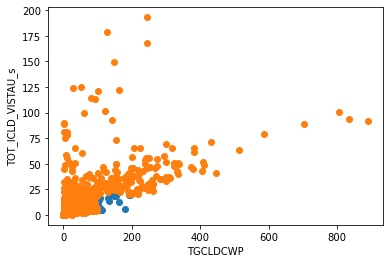

In [194]:
v = 'TGCLDCWP'
v2 = 'TOT_ICLD_VISTAU_s'
plt.scatter(a[v],a[v2])#plot(linewidth=0, marker='*')
plt.scatter(b[v],b[v2])#plot(linewidth=0, marker='*')
#b[v].plot(linewidth=0, marker='*')
plt.xlabel(v)
plt.ylabel(v2)

Text(0, 0.5, 'TOT_CLD_VISTAU_s')

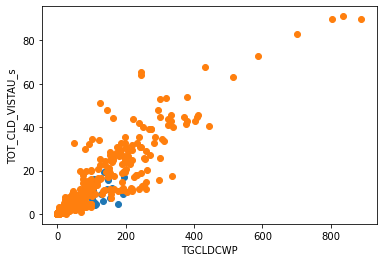

In [195]:
v = 'TGCLDCWP'
v2 = 'TOT_CLD_VISTAU_s'
plt.scatter(a[v],a[v2])#plot(linewidth=0, marker='*')
plt.scatter(b[v],b[v2])#plot(linewidth=0, marker='*')
#b[v].plot(linewidth=0, marker='*')
plt.xlabel(v)
plt.ylabel(v2)

Text(0, 0.5, 'TOT_ICLD_VISTAU_s')

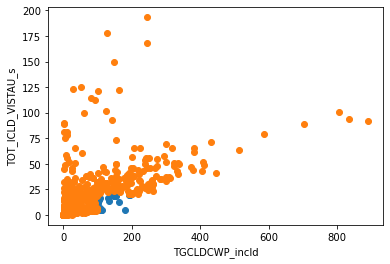

In [196]:
v = 'TGCLDCWP_incld'
v2 = 'TOT_ICLD_VISTAU_s'
plt.scatter(a[v],a[v2])#plot(linewidth=0, marker='*')
plt.scatter(b[v],b[v2])#plot(linewidth=0, marker='*')
#b[v].plot(linewidth=0, marker='*')
plt.xlabel(v)
plt.ylabel(v2)

Text(0, 0.5, 'CLDFREE')

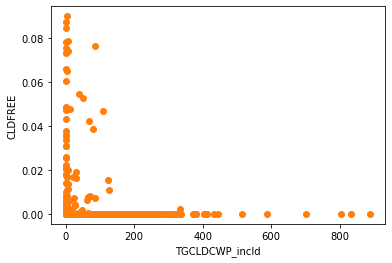

In [197]:
v = 'TGCLDCWP_incld'
v2 = 'CLDFREE'
plt.scatter(a[v],a[v2])#plot(linewidth=0, marker='*')
plt.scatter(b[v],b[v2])#plot(linewidth=0, marker='*')
#b[v].plot(linewidth=0, marker='*')
plt.xlabel(v)
plt.ylabel(v2)

Text(0, 0.5, 'CLDFREE')

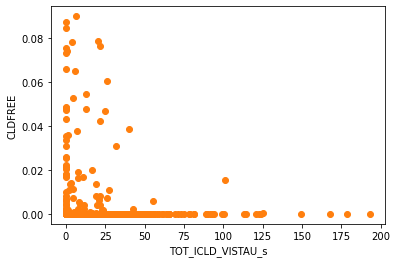

In [198]:
v = 'TOT_ICLD_VISTAU_s'
v2 = 'CLDFREE'
plt.scatter(a[v],a[v2])#plot(linewidth=0, marker='*')
plt.scatter(b[v],b[v2])#plot(linewidth=0, marker='*')
#b[v].plot(linewidth=0, marker='*')
plt.xlabel(v)
plt.ylabel(v2)

Text(0, 0.5, 'CLDTOT')

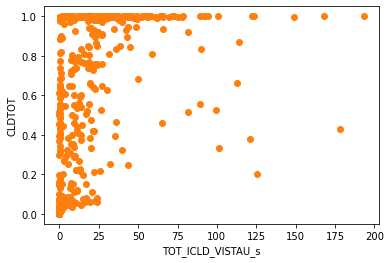

In [199]:
v = 'TOT_ICLD_VISTAU_s'
v2 = 'CLDTOT'
plt.scatter(a[v],a[v2])#plot(linewidth=0, marker='*')
plt.scatter(b[v],b[v2])#plot(linewidth=0, marker='*')
#b[v].plot(linewidth=0, marker='*')
plt.xlabel(v)
plt.ylabel(v2)

Text(0, 0.5, 'CLDTOT')

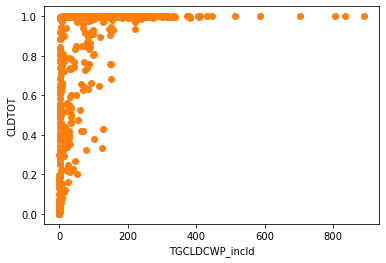

In [200]:
v = 'TGCLDCWP_incld'
v2 = 'CLDTOT'
plt.scatter(a[v],a[v2])#plot(linewidth=0, marker='*')
plt.scatter(b[v],b[v2])#plot(linewidth=0, marker='*')
#b[v].plot(linewidth=0, marker='*')
plt.xlabel(v)
plt.ylabel(v2)

<AxesSubplot:xlabel='time'>

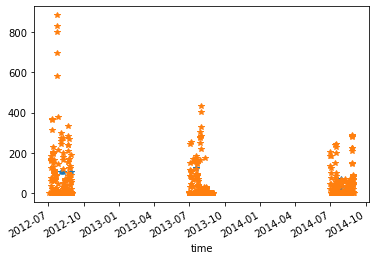

In [201]:
v = 'TGCLDLWP'
a[v].plot(linewidth=0, marker='*')
b[v].plot(linewidth=0, marker='*')



<AxesSubplot:xlabel='time'>

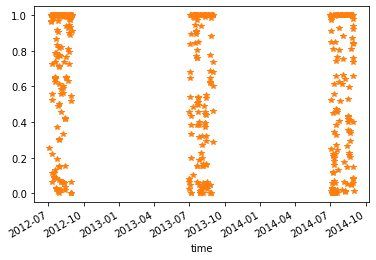

In [202]:
v = 'CLDTOT'
a[v].plot(linewidth=0, marker='*')
b[v].plot(linewidth=0, marker='*')


#### Mask values that don't have cloud top liquid

In [203]:
df_mod = df_mod[df_mod['mask_liq_cloudtop']]

In [204]:
df_mod['CWP_qcut']=pd.qcut(df_mod['TGCLDCWP'],6)# bins=bins, labels=labels)§

df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)



In [205]:
bins = pd.IntervalIndex.from_breaks([ 10,  40,  70,  100, 130, 160, 190,500])


df_mod['CWP_cut']=pd.cut(df_mod['TGCLDCWP'], bins=bins)#, labels=labels)

df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)

## Category of OA concentration

In [206]:
df_mod['OA_low'] = df_mod['OA']<df_mod['OA'].quantile(.34)
df_mod['OA_high']= df_mod['OA']>df_mod['OA'].quantile(.66)

In [207]:
#df_mod['OA_low'].loc[:,:] = df_mod['OA']<df_mod['OA'].quantile(.34)
mid_range = ( df_mod['OA'].quantile(.34)<df_mod['OA']) & (df_mod['OA']<df_mod['OA'].quantile(.66))
df_mod['OA_mid_range'] = mid_range

In [208]:

df_mod=df_mod.assign(OA_category= pd.NA)
df_mod.loc[df_mod['OA_high'], 'OA_category'] = 'OA high'
df_mod.loc[df_mod['OA_low'], 'OA_category'] = 'OA low'



In [209]:
import seaborn as sns

1330


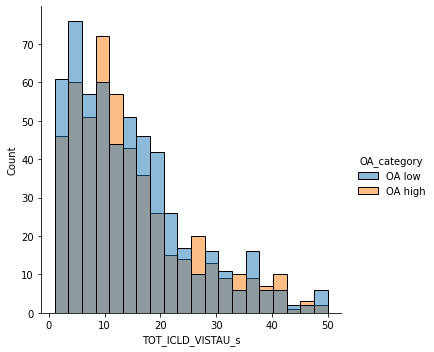

In [238]:
_df = (df_mod[(df_mod['OA_category'].notna()) & (df_mod['TOT_ICLD_VISTAU_s']>1)])
_df = _df[_df['TOT_ICLD_VISTAU_s']<50]
sns.displot(#x='TGCLDLWP', 
            x='TOT_ICLD_VISTAU_s',
            data=_df,
            hue='OA_category',
           #kind='swarm'
           )
#plt.ylim([0,250])
print(len(df_mod[df_mod['OA_category'].notna()]))

1330


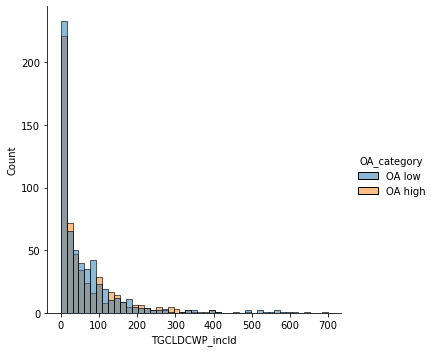

In [239]:
_df = (df_mod[(df_mod['OA_category'].notna()) & (df_mod['TOT_ICLD_VISTAU_s']>1)])
_df = _df[_df['TGCLDCWP_incld']<1000]
sns.displot(#x='TGCLDLWP', 
            x='TGCLDCWP_incld',
            data=_df,
            hue='OA_category',
           #kind='swarm'
           )
#plt.ylim([0,250])
print(len(df_mod[df_mod['OA_category'].notna()]))

1330


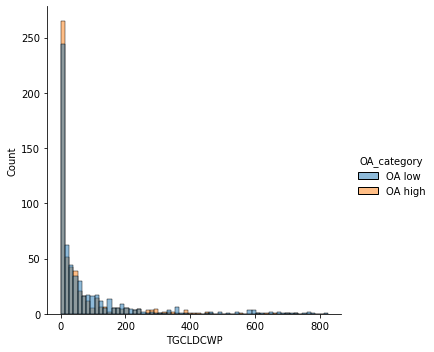

In [240]:
_df = (df_mod[(df_mod['OA_category'].notna()) & (df_mod['TOT_ICLD_VISTAU_s']>1)])
_df = _df#[_df['TGCLDCWP_incld']<1000]
sns.displot(#x='TGCLDLWP', 
            x='TGCLDCWP',
            data=_df,
            hue='OA_category',
           #kind='swarm'
           )
#plt.ylim([0,250])
print(len(df_mod[df_mod['OA_category'].notna()]))

1330


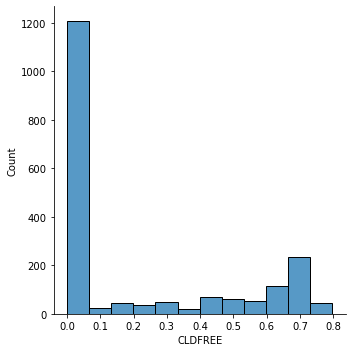

In [241]:
_df = df_mod#[(df_mod['OA_category'].notna()) & (df_mod['TOT_ICLD_VISTAU_s']>0)])
_df = _df#[_df['TGCLDCWP']<700]
sns.displot(#x='TGCLDLWP', 
            x='CLDFREE',
            data=_df,
            #hue='OA_category',
           #kind='swarm'
           )
#plt.ylim([0,250])
print(len(df_mod[df_mod['OA_category'].notna()]))

1330


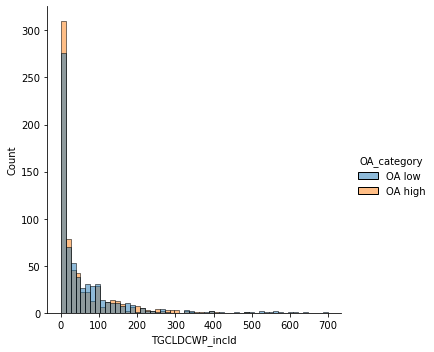

In [242]:
_df = df_mod[df_mod['TGCLDCWP_incld']<9999e99]#[(df_mod['OA_category'].notna()) & (df_mod['TOT_ICLD_VISTAU_s']>1)])
_df = _df#[_df['TGCLDCWP']<700]
sns.displot(#x='TGCLDLWP', 
            x='TGCLDCWP_incld',
            data=_df,
            hue='OA_category',
           #kind='swarm'
           )
#plt.ylim([0,250])
print(len(df_mod[df_mod['OA_category'].notna()]))

1330


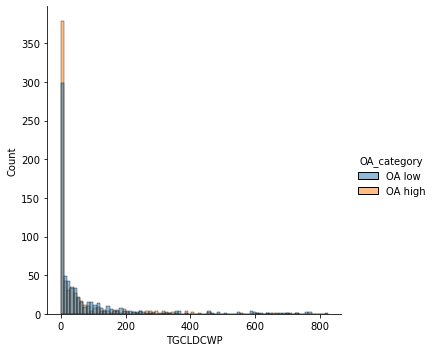

In [243]:
_df = df_mod#[(df_mod['OA_category'].notna()) & (df_mod['TOT_ICLD_VISTAU_s']>1)])
_df = _df#[_df['TGCLDCWP']<700]
sns.displot(#x='TGCLDLWP', 
            x='TGCLDCWP',
            data=_df,
            hue='OA_category',
           #kind='swarm'
           )
#plt.ylim([0,250])
print(len(df_mod[df_mod['OA_category'].notna()]))

1330


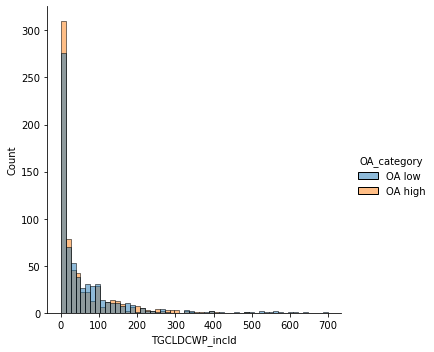

In [244]:
_df = df_mod#[(df_mod['OA_category'].notna()) & (df_mod['TOT_ICLD_VISTAU_s']>1)])
_df = _df#[_df['TGCLDCWP']<700]
sns.displot(#x='TGCLDLWP', 
            x='TGCLDCWP_incld',
            data=_df,
            hue='OA_category',
           #kind='swarm'
           )
#plt.ylim([0,250])
print(len(df_mod[df_mod['OA_category'].notna()]))

1330


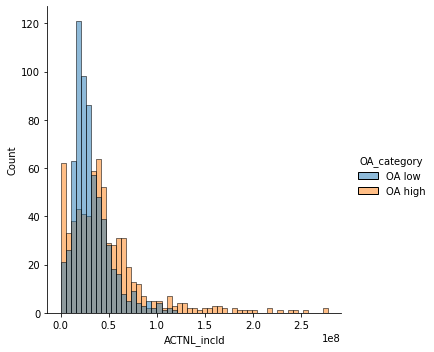

In [245]:
sns.displot(#x='TGCLDLWP', 
            x='ACTNL_incld',
            data=df_mod[~df_mod['OA_mid_range']].reset_index(),
            hue='OA_category',
           #kind='swarm'
           )
#plt.ylim([0,250])
print(len(df_mod[~df_mod['OA_mid_range']]))

In [246]:
import seaborn as sns

1956


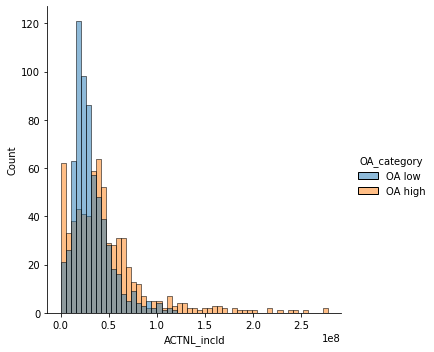

In [247]:
sns.displot(#x='TGCLDLWP', 
            x='ACTNL_incld',
            data=df_mod[~df_mod['OA_mid_range']].reset_index(),
            hue='OA_category',
           #kind='swarm'
           )
#plt.ylim([0,250])
print(len(_df['OA_category']))

In [248]:
import seaborn as sns

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 48.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 30.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg

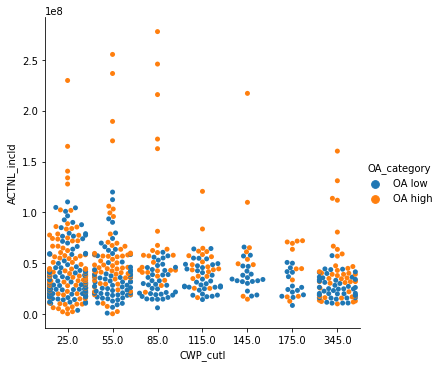

In [249]:
sns.catplot(x='CWP_cutl', 
            y='ACTNL_incld',
            #data=df_mod.reset_index(),
            #data=df_mod[~df_mod['OA_mid_range']].reset_index(),
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
           kind='swarm'
           )
#plt.ylim([0,250])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


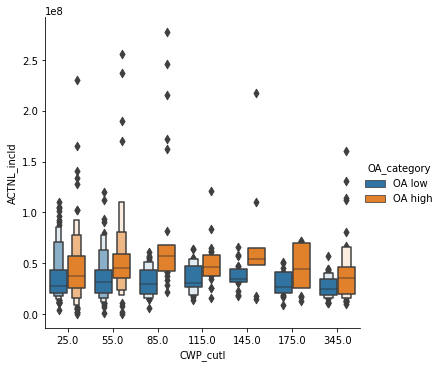

In [250]:
sns.catplot(x='CWP_cutl', 
            y='ACTNL_incld',
            #data=df_mod.reset_index(),
            #data=df_mod[~df_mod['OA_mid_range']].reset_index(),
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
           kind='boxen'
           )
#plt.ylim([0,250])

## Cloud optical thickness

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 47.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(ms

(0.0, 52.0)

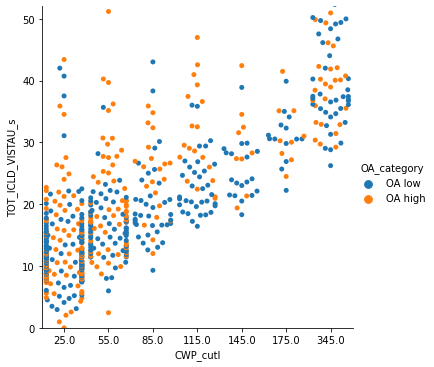

In [251]:
sns.catplot(x='CWP_cutl', 
            y='TOT_ICLD_VISTAU_s',
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
            kind='swarm',
           )
plt.ylim([0,52])

In [269]:
df_mod['TGCLDCWP']

time        lat        lon  
2012-07-01  60.785340  22.50     0.657910
                       23.75     1.359289
                       25.00     1.734373
                       26.25     0.116893
                       27.50     0.401289
                                  ...    
2014-08-31  61.727749  25.00     5.809092
                       26.25    30.988899
                       27.50    70.290726
                       28.75    64.200127
                       30.00     1.390970
Name: TGCLDCWP, Length: 1956, dtype: float32

<AxesSubplot:xlabel='TGCLDCWP', ylabel='TOT_CLD_VISTAU_s'>

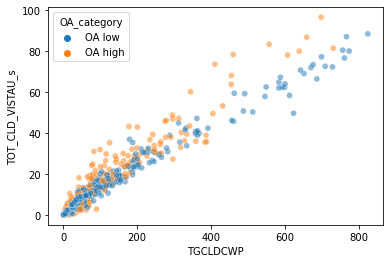

In [303]:
sns.scatterplot(x='TGCLDCWP', 
            y='TOT_CLD_VISTAU_s',
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],
            alpha=0.5,
            hue='OA_category',
            #kind='swarm',
           )
#plt.ylim([0,52])
#plt.xlim([0,400])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 56.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 21.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg

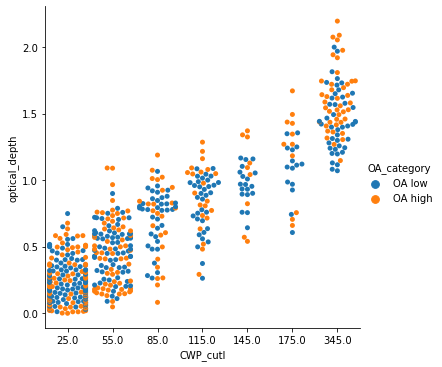

In [252]:
sns.catplot(x='CWP_cutl', 
            y='optical_depth',
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
            kind='swarm',
           )
#plt.ylim([0,52])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


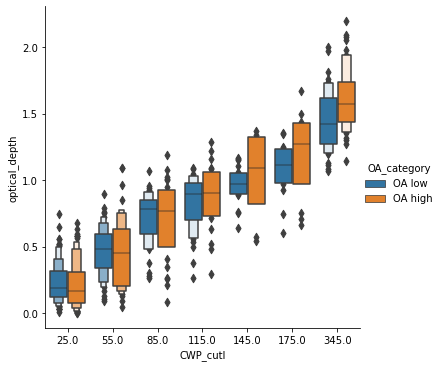

In [253]:
sns.catplot(x='CWP_cutl', 
            y='optical_depth',
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
            kind='boxen',
           )
#plt.ylim([0,52])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


(0.0, 80.0)

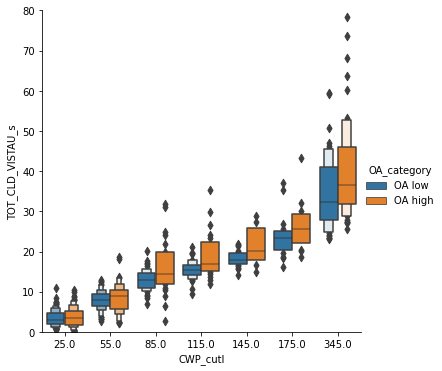

In [304]:
sns.catplot(x='CWP_cutl', 
            y='TOT_CLD_VISTAU_s',
            #data=df_mod.reset_index(),
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
           kind='boxen'
           )
plt.ylim([0,80])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


(0.0, 52.0)

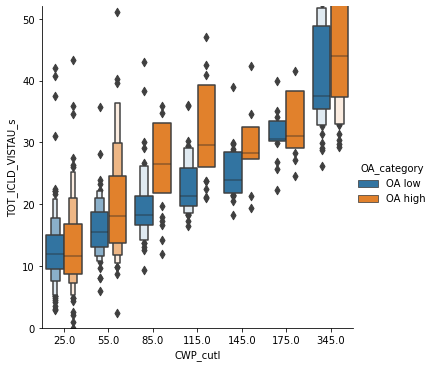

In [255]:
sns.catplot(x='CWP_cutl', 
            y='TOT_ICLD_VISTAU_s',
            #data=df_mod.reset_index(),
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
           kind='boxen'
           )
plt.ylim([0,52])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 79.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 56.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(ms

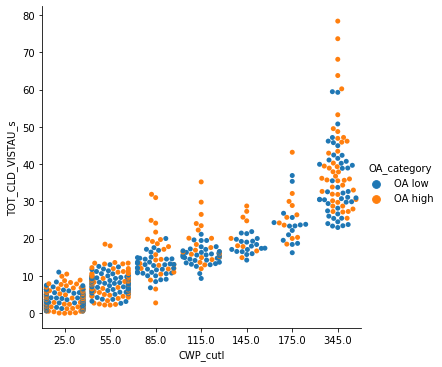

In [256]:
sns.catplot(x='CWP_cutl', 
            y='TOT_CLD_VISTAU_s',
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue ='OA_category',
            kind='swarm',
            hue_order=['OA low','OA high'],
           )
#plt.ylim([0,250])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


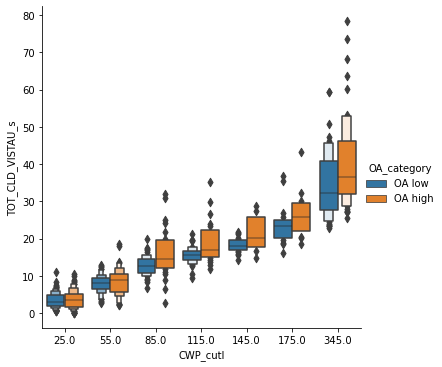

In [257]:
sns.catplot(x='CWP_cutl', 
            y='TOT_CLD_VISTAU_s',
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue ='OA_category',
            kind='boxen',
            hue_order=['OA low','OA high'],
           )
#plt.ylim([0,250])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 48.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 30.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg

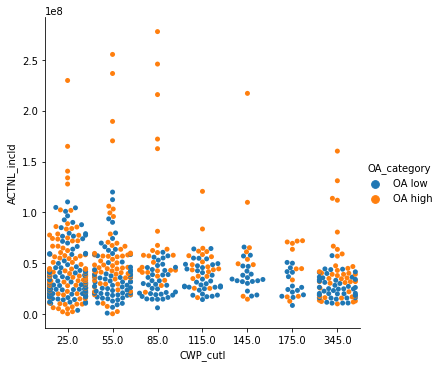

In [258]:
sns.catplot(x='CWP_cutl', 
            y='ACTNL_incld',
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),

            hue='OA_category',
           kind='swarm'
           )

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


(0.0, 25.0)

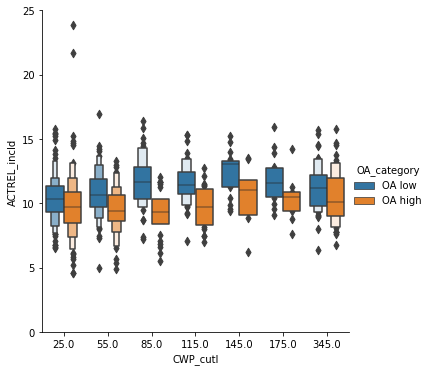

In [259]:
sns.catplot(x='CWP_cutl', 
            y='ACTREL_incld',
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
            kind='boxen',
           )
plt.ylim([0,25])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 42.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 24.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg

(0.0, 25.0)

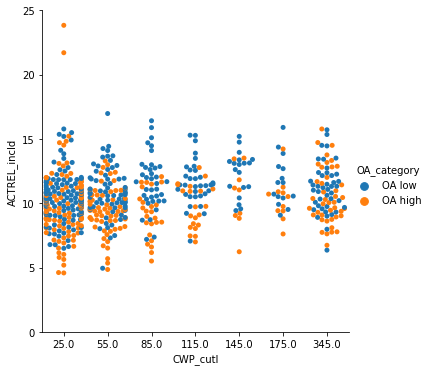

In [260]:
sns.catplot(x='CWP_cutl', 
            y='ACTREL_incld',
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
            kind='swarm',
           )
plt.ylim([0,25])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 42.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 24.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg

(0.0, 25.0)

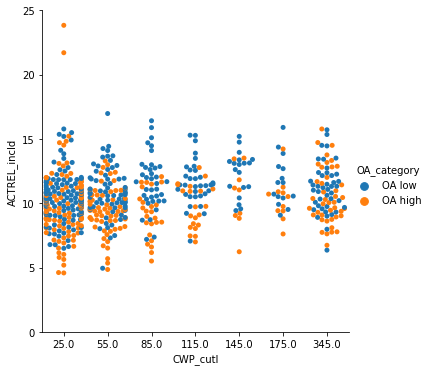

In [261]:
sns.catplot(x='CWP_cutl', 
            y='ACTREL_incld',
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue ='OA_category',
            kind='swarm',
            hue_order=['OA low','OA high'],
           )
#plt.ylim([0,250])
plt.ylim([0,25])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 48.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 30.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg

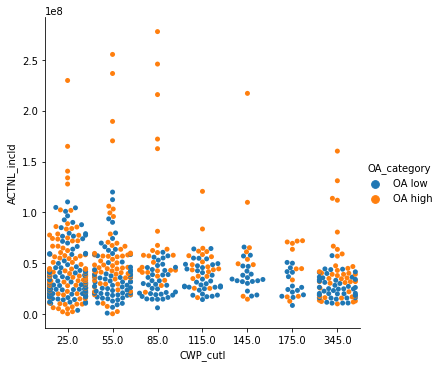

In [262]:
sns.catplot(x='CWP_cutl', 
            y='ACTNL_incld',
            #data=df_mod.reset_index(),
            #data=df_mod[~df_mod['OA_mid_range']].reset_index(),
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
           kind='swarm'
           )
#plt.ylim([0,250])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


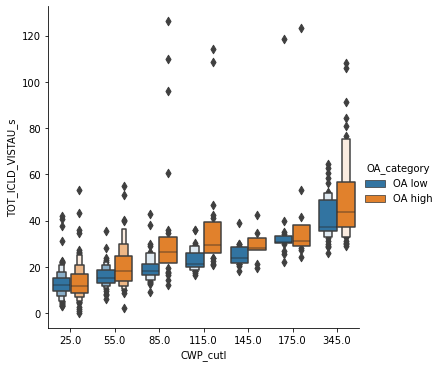

In [263]:
sns.catplot(x='CWP_cutl', 
            y='TOT_ICLD_VISTAU_s',
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
            kind='boxen',
           )
#plt.ylim([0,250])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 47.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(ms

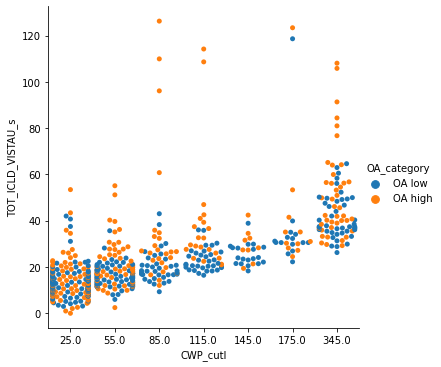

In [264]:
sns.catplot(x='CWP_cutl', 
            y='TOT_ICLD_VISTAU_s',
            #data=df_mod.reset_index(),
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
           kind='swarm'
           )
#plt.ylim([0,250])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 79.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 56.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(ms

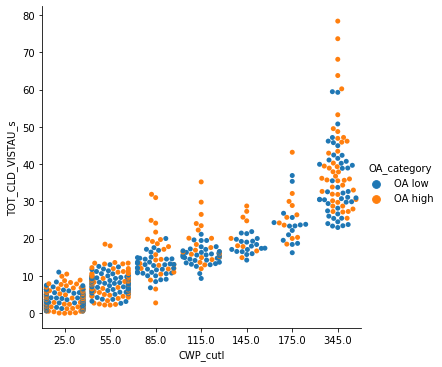

In [265]:
sns.catplot(x='CWP_cutl', 
            y='TOT_CLD_VISTAU_s',
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue ='OA_category',
            kind='swarm',
            hue_order=['OA low','OA high'],
           )
#plt.ylim([0,250])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


(0.0, 25.0)

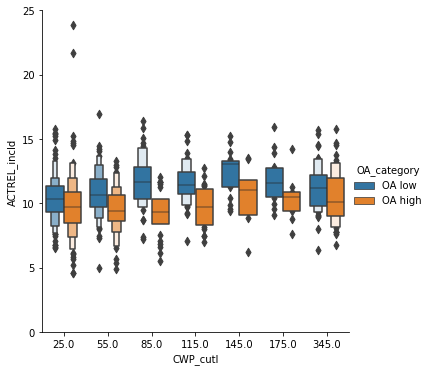

In [266]:
sns.catplot(x='CWP_cutl', 
            y='ACTREL_incld',
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
            kind='boxen',
           )
plt.ylim([0,25])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 42.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 24.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg

(0.0, 25.0)

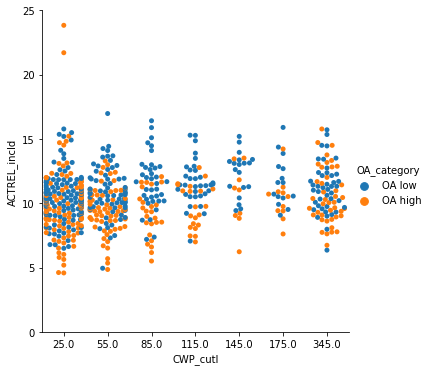

In [267]:
sns.catplot(x='CWP_cutl', 
            y='ACTREL_incld',
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
            kind='swarm',
           )
plt.ylim([0,25])